### Image processing

In [14]:
import imageio
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [15]:
def preprocess_imagery(path):
    '''
    Pre process satellite imagery. We check for nans in the composite images,
    and then we load them into the [0,1] range.
    Input: TIF files downloaded from GEE (224x224x7)
    '''
    #reading image
    path=str(path).strip('b').strip("'")
    image=imageio.imread(path)
    if np.sum(np.isnan(image))>0:
        #print(str(np.sum(np.isnan(image)))+"nans found")
        #taking the mean of the image, per channel
        mean=np.nanmean(image,axis=(0,1))
        #replacing NaN with per channel mean
        replacement=np.isnan(image)*mean
        image[np.isnan(image)]=replacement[np.isnan(image)]  
        #print(str(np.sum(np.isnan(image)))+"nans found")
        nan_channels = np.all(np.isnan(image), axis=(0, 1))
        # Replacing NaN with 0 where all values in a channel are NaN
        image[:, :, nan_channels] = np.nan_to_num(image[:, :, nan_channels])
        image=image/255
    return image

In [16]:
image_files = [f for f in os.listdir("../GEE_Images")]
image_files=image_files[:20000]
len(image_files)

5000

In [17]:
""" run when mp10.txt not present
image_info=[]
for image in image_files:
    name,_=os.path.splitext(image)
    image_info.append(['_'.join(name.split(' ')[0].split('_')[:-1]),name.split(' ')[0].split('_')[-1]])
df=pd.read_csv('processed_data.csv')
mp10=[]
for info in image_info:
    mp10.append(df[(df['station']==info[0]) & (df['Date']==info[1])]['mp10'].values[0])
    """

" run when mp10.txt not present\nimage_info=[]\nfor image in image_files:\n    name,_=os.path.splitext(image)\n    image_info.append(['_'.join(name.split(' ')[0].split('_')[:-1]),name.split(' ')[0].split('_')[-1]])\ndf=pd.read_csv('processed_data.csv')\nmp10=[]\nfor info in image_info:\n    mp10.append(df[(df['station']==info[0]) & (df['Date']==info[1])]['mp10'].values[0])\n    "

In [18]:
with open('mp10.txt', 'r') as f:
  mp10 = [float(line.strip()) for line in f]
mp10=mp10[:20000]

In [19]:

for a in range(len(image_files)):
    image_files[a]="../GEE_Images/"+image_files[a]
train_image_files, test_image_files, train_mp10, test_mp10 = train_test_split(
    image_files, mp10, test_size=0.2, random_state=42)


### Model using one NN 224,224,6 
#### Generator for 224,224,6

In [7]:
def data_generator(image_files, lista):
    i=0
    for file in image_files:
        mp10=tf.convert_to_tensor(lista[i],dtype=tf.float32)
        image = preprocess_imagery(file)
        image=tf.convert_to_tensor(image, dtype=tf.float32)
        yield image, mp10

# Crear el Dataset
def create_dataset(image_files,lista, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, lista],
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset=dataset.repeat()
    return dataset

In [11]:
""" dont run, alternative to loading images
for file in image_files:
    image = preprocess_imagery("../GEE_Images/"+file)
    images.append(tf.convert_to_tensor(image, dtype=tf.float32))
images=np.array(images)
mp10=np.array(mp10)
X_train, X_test, y_train, y_test = train_test_split(images, mp10, test_size=0.2, random_state=42)
"""

/tmp/ipykernel_13918/850835770.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
2024-05-21 23:51:55.370017: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_13918/850835770.py:12: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape):
    model = models.Sequential()

    # Capa convolucional
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # Capa de pooling
    model.add(layers.AveragePooling2D((2, 2)))

    # Otras capas convolucionales y de pooling para aumentar la profundidad
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))

    # Aplanar los datos para alimentar la capa densa
    model.add(layers.Flatten())

    # Capas densas para la parte final de la red
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularización con dropout
    model.add(layers.Dense(1, activation='linear'))  # Capa de salida con activación lineal para valores float

    return model

# Crear el modelo
input_shape = (224, 224, 6)
model = build_model(input_shape)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
model.summary()


c:\Users\benja\anaconda3\envs\ee\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 111, 111, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 54, 54, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 26, 26, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,397,473 (169.36 MB)

 Trainable params: 44,397,473 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Configuración de entrenamiento
batch_size = 2000
epochs = 15
full_history=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size

for epoch in range(epochs):
    print("Epoch: ",epoch+1)
    epoch_history = {'loss': [], 'mae': []}
    for part in range(num_parts):
        start = part * batch_size
        end = (part + 1) * batch_size
        image_files_part = train_image_files[start:end]
        mp10_part = mp10[start:end]
        
        dataset = create_dataset(image_files_part, mp10_part, batch_size)
        
        # Entrenar el modelo con la parte actual del conjunto de datos
        history=model.fit(dataset, epochs=1,batch_size=50,steps_per_epoch=batch_size//50)

        epoch_history['loss'].append(history.history['loss'][0])
        epoch_history['mae'].append(history.history['mae'][0])
        print('Part: ',part+1)
        print('Loss: ',history.history['loss'][0])
        print('MAE: ',history.history['mae'][0])
    full_history.append({
        'epoch': epoch + 1,
        'loss': np.mean(epoch_history['loss']),
        'mae': np.mean(epoch_history['mae'])
    })
    print('Epoch Loss: ',np.mean(epoch_history['loss']))
    print('Epoch MAE: ',np.mean(epoch_history['mae']))
        
# Si quedan imágenes que no llenan un batch completo al final
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    
    dataset = create_dataset(image_files_part, mp10_part, batch_size)
    history = model.fit(dataset, epochs=1,batch_size=50)
    full_history.append({
        'epoch': epochs,
        'loss': history.history['loss'][0],
        'mae': history.history['mae'][0]
    })

Part: 1, Epoch: 1


C:\Users\benja\AppData\Local\Temp\ipykernel_20796\3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)


In [15]:
# Entrenamos el modelo
history = model.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=16)


2024-05-22 00:02:19.920084: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1541406720 exceeds 10% of free system memory.


Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 604ms/step - accuracy: 0.0000e+00 - loss: 826671104.0000 - mae: 7781.1650 - val_accuracy: 0.0031 - val_loss: 2745.6108 - val_mae: 43.5256
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 598ms/step - accuracy: 0.0000e+00 - loss: 2389.3083 - mae: 38.9321 - val_accuracy: 0.0031 - val_loss: 1868.4949 - val_mae: 32.4535
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 608ms/step - accuracy: 0.0000e+00 - loss: 1946.2864 - mae: 33.3932 - val_accuracy: 0.0031 - val_loss: 1801.4866 - val_mae: 31.5512
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 630ms/step - accuracy: 0.0000e+00 - loss: 1924.0051 - mae: 31.6385 - val_accuracy: 0.0031 - val_loss: 1884.2473 - val_mae: 33.3156
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 619ms/step - accuracy: 0.0000e+00 - loss: 1748.4365 - mae: 31.2740 - val_accuracy: 0.0031 - val_loss: 1792.4309 - val_mae: 31.0692
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 605ms/step - accuracy: 0.0000e+00 - loss: 1612.0415 - mae: 30.6824 - val_accuracy: 0.0

In [16]:
test=X_test[0]
test=np.expand_dims(test, axis=0)
np.shape(test)

(1, 224, 224, 6)

In [17]:
prediction=model.predict(test)
print(prediction,y_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[[62.967506]] 64.6875


In [18]:
# Evaluamos el modelo
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.0000e+00 - loss: 1871.8628 - mae: 29.4749
Test Loss: [2024.589111328125, 31.186094284057617, 0.0]


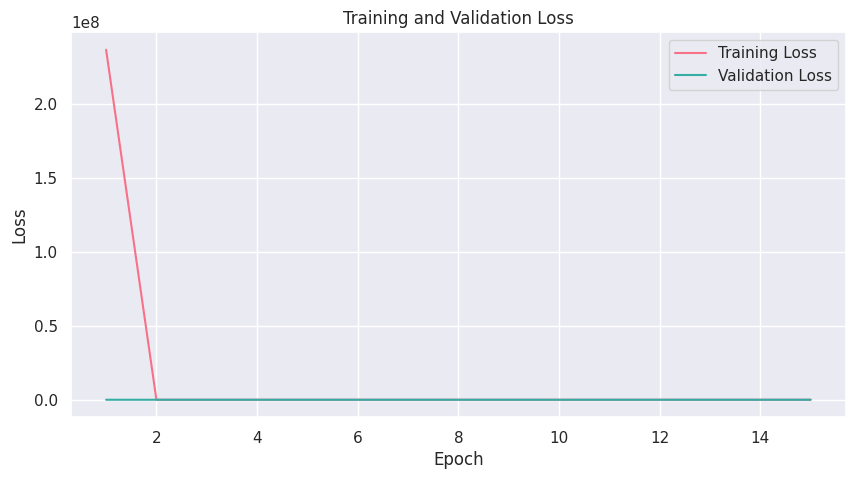

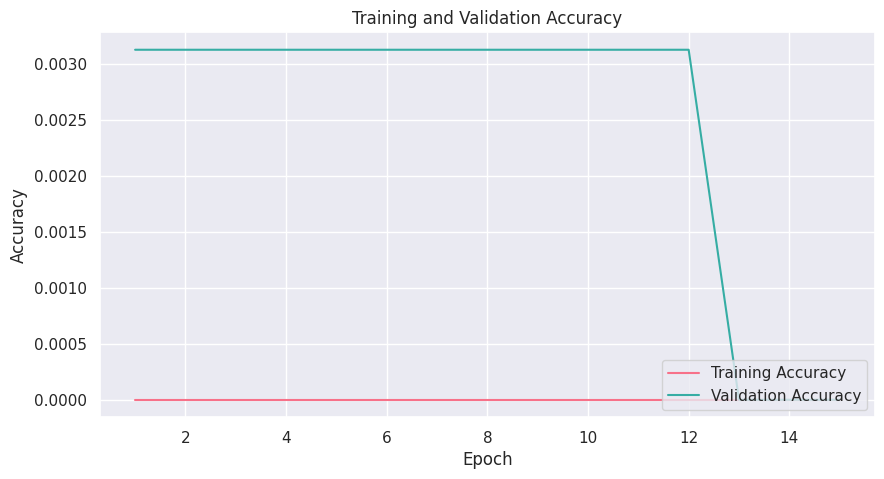

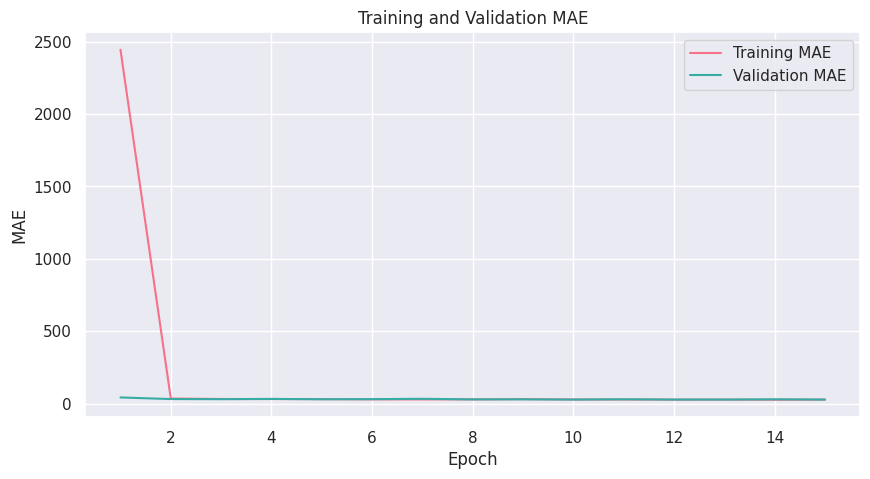

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Obtener las métricas de entrenamiento y validación del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Crear un DataFrame para Seaborn
epochs = range(1, len(train_loss) + 1)
history_df = pd.DataFrame({'Epoch': epochs,
                           'Training Loss': train_loss,
                           'Validation Loss': val_loss,
                           'Training Accuracy': train_acc,
                           'Validation Accuracy': val_acc,
                           'Training MAE': train_mae,
                           'Validation MAE': val_mae})

# Graficar las pérdidas
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(history_df, id_vars=['Epoch'], value_vars=['Training Loss', 'Validation Loss']),
             palette="husl")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Graficar la precisión
plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(history_df, id_vars=['Epoch'], value_vars=['Training Accuracy', 'Validation Accuracy']),
             palette="husl")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Graficar el MAE
plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(history_df, id_vars=['Epoch'], value_vars=['Training MAE', 'Validation MAE']),
             palette="husl")
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.show()


### For 6 NN with 224,224

In [20]:

def separar_imagen(imagen):
    """
    Separa una imagen con dimensiones (224, 224, 6) en 6 imágenes con dimensiones (224, 224, 1).

    Args:
    imagen (numpy.ndarray): Imagen original con dimensiones (224, 224, 6).

    Returns:
    tuple: Una tupla con 6 numpy.ndarrays, cada uno con dimensiones (224, 224, 1).
    """
    # Verificar que la imagen tenga las dimensiones correctas
    assert imagen.shape == (224, 224, 6), "La imagen debe tener dimensiones (224, 224, 6)"
    
    # Separar la imagen en 6 partes
    imagenes_separadas = tuple(imagen[:, :, i][:, :, np.newaxis] for i in range(6))
    
    return imagenes_separadas

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout

def build_model_layer():
    # Crear el modelo secuencial
    model = Sequential()

    # Añadir la capa de convolución 2D
    model.add(Conv2D(filters=4, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1)))

    # Añadir la capa de Average Pooling
    model.add(AveragePooling2D(pool_size=(2, 2)))
    # Segunda capa de convolución 2D
    model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Tercera capa de convolución 2D
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Cuarta capa de convolución 2D
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Aplanar la salida de la capa de pooling
    model.add(Flatten())

    # Añadir una capa densa
    model.add(Dense(units=64, activation='relu'))

    # Añadir la capa de Dropout
    model.add(Dropout(rate=0.5))

    # Añadir la capa de salida con activación lineal
    model.add(Dense(units=1, activation='linear'))
    return model

#### Global settings for the layered models

In [23]:
batch_size = 1000
epochs = 15

#### Model for layer 0

In [24]:
model_0=build_model_layer()
# Compilar el modelo
model_0.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

# Resumen del modelo
model_0.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 111, 111, 4)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 54, 54, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 26, 26, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 12, 12, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,409 (591.44 KB)

 Trainable params: 151,409 (591.44 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Configuración de entrenamiento
full_history_0=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = np.array(mp10[start:end])
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[0],dtype=tf.float32))
    images=np.array(images)
    history=model_0.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_0.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = np.array(mp10[num_parts * batch_size:])
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[0],dtype=tf.float32))
    images=np.array(images)
    history=model_0.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_0.append([history.history['loss'],history.history['mae']])

Part:  1


C:\Users\benja\AppData\Local\Temp\ipykernel_15544\3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)


Epoch 1/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 337659.1875 - mae: 267.3012
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2364.9158 - mae: 40.8181
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2273.8760 - mae: 39.3511
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1911.7589 - mae: 35.5353
Epoch 5/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1682.4113 - mae: 32.5716
Epoch 6/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1866.8500 - mae: 34.3897
Epoch 7/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1767.0337 - mae: 33.2910
Epoch 8/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1732.9980 - mae: 32.6565
Part:  2
Epoch 1/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1213.7108 - mae: 27.1279
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1223.1008 - mae: 27.2631
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1185.3975 - mae: 27.2396
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1201.6937 - mae: 

In [ ]:
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[0],dtype=tf.float32))
images=np.array(images)
op_0=model_0.evaluate(images,test_mp10)

/tmp/ipykernel_4501/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4501/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 959s 473s/step - loss: 11695.4385 - mae: 107.9176


2024-05-29 21:24:35.420476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


#### Model for layer 1

In [ ]:
model_1=build_model_layer()
# Compilar el modelo
model_1.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 111, 111, 4)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 54, 54, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 26, 26, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 12, 12, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,409 (591.44 KB)

 Trainable params: 151,409 (591.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Configuración de entrenamiento
full_history_1=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[1],dtype=tf.float32))
    images=np.array(images)
    history=model_1.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_1.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[1],dtype=tf.float32))
    images=np.array(images)
    
    history=model_1.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_1.append([history.history['loss'],history.history['mae']])

Part:  1
Epoch 1/5


/tmp/ipykernel_4501/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4501/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 695562.8750 - mae: 507.9460
Epoch 2/5


2024-05-29 21:28:16.206168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 832326.1250 - mae: 595.4119
Epoch 3/5


2024-05-29 21:31:54.222229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 180861.8125 - mae: 254.1807
Epoch 4/5


2024-05-29 21:35:37.640562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 55698.1562 - mae: 145.8340
Epoch 5/5


2024-05-29 21:39:24.803069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 44832.4570 - mae: 129.2930
Part:  2
Epoch 1/5


2024-05-29 21:43:06.945351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 50928.9883 - mae: 141.8104
Epoch 2/5


2024-05-29 21:46:53.467754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - loss: 34027.1250 - mae: 117.6254
Epoch 3/5


2024-05-29 21:50:29.647866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 29117.3984 - mae: 108.8076
Epoch 4/5


2024-05-29 21:54:09.902138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 17745.1621 - mae: 87.0638
Epoch 5/5


2024-05-29 21:57:54.550503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 10989.7334 - mae: 73.4719
Part:  3
Epoch 1/5


2024-05-29 22:01:36.638590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 7327.5757 - mae: 61.2444
Epoch 2/5


2024-05-29 22:05:19.481995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 4695.6313 - mae: 51.4785
Epoch 3/5


2024-05-29 22:09:00.425560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 2387.2910 - mae: 37.5559
Epoch 4/5


2024-05-29 22:12:46.190960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 6427.0557 - mae: 54.5825
Epoch 5/5


2024-05-29 22:16:33.039190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 1250.4269 - mae: 27.7884
Part:  4
Epoch 1/5


2024-05-29 22:20:17.858584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 3143.8938 - mae: 53.5398
Epoch 2/5


2024-05-29 22:24:00.474791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 3143.7305 - mae: 54.0513
Epoch 3/5


2024-05-29 22:27:45.930794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 2977.5625 - mae: 52.1941
Epoch 4/5


2024-05-29 22:31:31.171384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 2747.4055 - mae: 49.6387
Epoch 5/5


2024-05-29 22:35:11.585181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 2681.3403 - mae: 48.0845
Part:  5
Epoch 1/5


2024-05-29 22:38:53.882418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 2430.4514 - mae: 45.4086
Epoch 2/5


2024-05-29 22:42:41.805065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 231s 231s/step - loss: 2420.0166 - mae: 45.1086
Epoch 3/5


2024-05-29 22:46:32.415900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 2201.4360 - mae: 43.5188
Epoch 4/5


2024-05-29 22:50:16.646381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 2131.5457 - mae: 42.6941
Epoch 5/5


2024-05-29 22:54:04.907715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 1965.9187 - mae: 41.4572
Part:  6
Epoch 1/5


2024-05-29 22:57:53.308401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 17178.6875 - mae: 129.7535
Epoch 2/5


2024-05-29 23:01:41.504467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 17034.0918 - mae: 129.2947
Epoch 3/5


2024-05-29 23:05:29.848362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 16785.4844 - mae: 128.2047
Epoch 4/5


2024-05-29 23:09:16.561592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 16154.2178 - mae: 125.3701
Epoch 5/5


2024-05-29 23:13:04.888778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 14933.2041 - mae: 119.3366
Part:  7
Epoch 1/5


2024-05-29 23:16:50.716812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 2764.4524 - mae: 45.4713
Epoch 2/5


2024-05-29 23:20:30.423543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 214s 214s/step - loss: 3609.3086 - mae: 49.2291
Epoch 3/5


2024-05-29 23:24:04.131693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 3772.6790 - mae: 50.9568
Epoch 4/5


2024-05-29 23:27:42.269403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 3303.1421 - mae: 47.3760
Epoch 5/5


2024-05-29 23:31:21.978524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 2818.4807 - mae: 45.3327
Part:  8
Epoch 1/5


2024-05-29 23:35:01.571707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 1053.9801 - mae: 25.0806
Epoch 2/5


2024-05-29 23:38:40.310971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 1033.7706 - mae: 24.4638
Epoch 3/5


2024-05-29 23:42:21.020921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 907.9823 - mae: 22.5852
Epoch 4/5


2024-05-29 23:46:07.356604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 767.9099 - mae: 21.8181
Epoch 5/5


2024-05-29 23:49:50.005291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 664.8156 - mae: 21.8948
Part:  9
Epoch 1/5


2024-05-29 23:53:33.720638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 4234.2700 - mae: 62.5836
Epoch 2/5


2024-05-29 23:57:19.430356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 4456.6304 - mae: 64.5146
Epoch 3/5


2024-05-30 00:01:04.659198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 4416.9683 - mae: 64.0490
Epoch 4/5


2024-05-30 00:04:49.570043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 4384.1211 - mae: 63.9253
Epoch 5/5


2024-05-30 00:08:29.210167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 4306.3564 - mae: 63.5296
Part:  10
Epoch 1/5


2024-05-30 00:12:13.425741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 231s 231s/step - loss: 3046.3435 - mae: 52.4433
Epoch 2/5


2024-05-30 00:16:04.309832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 3010.1060 - mae: 52.4492
Epoch 3/5


2024-05-30 00:19:45.622210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 230s 230s/step - loss: 3043.3660 - mae: 52.4188
Epoch 4/5


2024-05-30 00:23:35.817046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 231s 231s/step - loss: 2942.9685 - mae: 51.6246
Epoch 5/5


2024-05-30 00:27:26.610839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 230s 230s/step - loss: 2995.0173 - mae: 52.3214
Part:  11
Epoch 1/5


2024-05-30 00:31:16.410885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 8601.3164 - mae: 90.8890
Epoch 2/5


2024-05-30 00:35:03.222884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 8640.6982 - mae: 91.1103
Epoch 3/5


2024-05-30 00:38:48.212874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 8413.6113 - mae: 89.7880
Epoch 4/5


2024-05-30 00:42:36.455120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 8551.6846 - mae: 90.4478
Epoch 5/5


2024-05-30 00:46:23.385802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 8078.3931 - mae: 87.4575
Part:  12
Epoch 1/5


2024-05-30 00:50:06.116799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 17873.5488 - mae: 132.2103
Epoch 2/5


2024-05-30 00:53:46.621862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 17361.8262 - mae: 129.9010
Epoch 3/5


2024-05-30 00:57:31.395017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 17291.4941 - mae: 129.3683
Epoch 4/5


2024-05-30 01:01:17.896996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 17044.0098 - mae: 128.1271
Epoch 5/5


2024-05-30 01:04:58.200056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 16602.1211 - mae: 125.7030
Part:  13
Epoch 1/5


2024-05-30 01:08:42.630240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 1752.5177 - mae: 35.2419
Epoch 2/5


2024-05-30 01:12:29.290629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 1672.2498 - mae: 34.9965
Epoch 3/5


2024-05-30 01:16:12.921879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 2021.3053 - mae: 37.2757
Epoch 4/5


2024-05-30 01:19:59.688962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 2043.5442 - mae: 37.5989
Epoch 5/5


2024-05-30 01:23:41.916452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 2122.5464 - mae: 37.0757
Part:  14
Epoch 1/5


2024-05-30 01:27:27.620664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 2219.8535 - mae: 32.6026
Epoch 2/5


2024-05-30 01:31:12.362749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 1967.9172 - mae: 30.7200
Epoch 3/5


2024-05-30 01:35:00.137389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 1795.6312 - mae: 28.5974
Epoch 4/5


2024-05-30 01:38:46.842097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 1248.8041 - mae: 25.0805
Epoch 5/5


2024-05-30 01:42:29.197422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 864.0924 - mae: 22.0175
Part:  15
Epoch 1/5


2024-05-30 01:46:15.790030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 491.7895 - mae: 16.3958
Epoch 2/5


2024-05-30 01:49:58.406149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 207.6237 - mae: 11.9799
Epoch 3/5


2024-05-30 01:53:40.718136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 159.0977 - mae: 11.0105
Epoch 4/5


2024-05-30 01:57:24.766637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 170.7885 - mae: 11.2482
Epoch 5/5


2024-05-30 02:01:04.060418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 185.5243 - mae: 11.2405
Part:  16
Epoch 1/5


2024-05-30 02:04:46.287701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 266.6927 - mae: 14.6289
Epoch 2/5


2024-05-30 02:08:30.947498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 248.9986 - mae: 14.5807
Epoch 3/5


2024-05-30 02:12:11.796372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 251.0094 - mae: 15.0258
Epoch 4/5


2024-05-30 02:15:57.552578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 270.1086 - mae: 15.8587
Epoch 5/5


2024-05-30 02:19:43.073329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 274.7927 - mae: 16.0153


2024-05-30 02:23:23.152665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [ ]:
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[1],dtype=tf.float32))
images=np.array(images)
op_1=model_1.evaluate(images,test_mp10)

/tmp/ipykernel_4501/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4501/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


4/4 ━━━━━━━━━━━━━━━━━━━━ 890s 222s/step - loss: 12474.4912 - mae: 111.6130


2024-05-30 02:38:12.868391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


#### Model for layer 2

In [ ]:
model_2=build_model_layer()
# Compilar el modelo
model_2.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 111, 111, 4)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 54, 54, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_10            │ (None, 26, 26, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_11            │ (None, 12, 12, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,409 (591.44 KB)

 Trainable params: 151,409 (591.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
full_history_2=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[2],dtype=tf.float32))
    images=np.array(images)
    history=model_2.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_2.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[2],dtype=tf.float32))
    images=np.array(images)
    history=model_2.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_2.append([history.history['loss'],history.history['mae']])

Part:  1
Epoch 1/5


/tmp/ipykernel_4501/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4501/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 843071.1250 - mae: 553.0397
Epoch 2/5


2024-05-30 02:41:53.802545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 2632689.7500 - mae: 1033.4312
Epoch 3/5


2024-05-30 02:45:37.467688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 755111.1875 - mae: 511.1872
Epoch 4/5


2024-05-30 02:49:21.848944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 130661.6797 - mae: 212.8872
Epoch 5/5


2024-05-30 02:53:00.144122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 39087.6172 - mae: 123.5904
Part:  2
Epoch 1/5


2024-05-30 02:56:47.854000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 42557.3945 - mae: 134.4095
Epoch 2/5


2024-05-30 03:00:31.136782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 27282.2461 - mae: 118.3561
Epoch 3/5


2024-05-30 03:04:12.895443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 10386.5078 - mae: 77.0762
Epoch 4/5


2024-05-30 03:07:55.207071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 212s 212s/step - loss: 4821.4600 - mae: 52.7248
Epoch 5/5


2024-05-30 03:11:27.229114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 3572.0410 - mae: 46.1414
Part:  3
Epoch 1/5


2024-05-30 03:15:07.388979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - loss: 2313.2205 - mae: 36.9974
Epoch 2/5


2024-05-30 03:18:43.156033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 1593.3972 - mae: 32.1074
Epoch 3/5


2024-05-30 03:22:24.930594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 1037.1058 - mae: 28.8746
Epoch 4/5


2024-05-30 03:26:03.323990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 1021.0545 - mae: 29.5557
Epoch 5/5


2024-05-30 03:29:46.025512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 1137.3225 - mae: 30.6183
Part:  4
Epoch 1/5


2024-05-30 03:33:31.221308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 217s 217s/step - loss: 3072.8784 - mae: 54.2927
Epoch 2/5


2024-05-30 03:37:08.275942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 2994.6970 - mae: 54.2003
Epoch 3/5


2024-05-30 03:40:54.544691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 2987.7759 - mae: 54.3026
Epoch 4/5


2024-05-30 03:44:36.375955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 3007.0305 - mae: 53.9376
Epoch 5/5


2024-05-30 03:48:17.355733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 2898.4995 - mae: 53.4395
Part:  5
Epoch 1/5


2024-05-30 03:52:05.301407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 2530.9319 - mae: 49.2801
Epoch 2/5


2024-05-30 03:55:44.225491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 2440.1790 - mae: 47.4003
Epoch 3/5


2024-05-30 03:59:30.628510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 2388.6597 - mae: 46.4390
Epoch 4/5


2024-05-30 04:03:12.188031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 2316.1475 - mae: 46.9356
Epoch 5/5


2024-05-30 04:06:58.055228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 2264.6311 - mae: 46.1500
Part:  6
Epoch 1/5


2024-05-30 04:10:39.327317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 16789.5000 - mae: 126.3764
Epoch 2/5


2024-05-30 04:14:17.398335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 12596.7832 - mae: 96.9486
Epoch 3/5


2024-05-30 04:18:02.706651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 48534.4883 - mae: 175.9608
Epoch 4/5


2024-05-30 04:21:46.535618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 12935.0273 - mae: 103.9362
Epoch 5/5


2024-05-30 04:25:30.151451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 17003.7754 - mae: 128.3768
Part:  7
Epoch 1/5


2024-05-30 04:29:10.268358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 211s 211s/step - loss: 3561.7605 - mae: 58.8664
Epoch 2/5


2024-05-30 04:32:41.517051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 217s 217s/step - loss: 3759.7581 - mae: 60.8214
Epoch 3/5


2024-05-30 04:36:18.474174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 208s 208s/step - loss: 3818.0996 - mae: 61.5395
Epoch 4/5


2024-05-30 04:39:46.136877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 3846.7024 - mae: 61.8103
Epoch 5/5


2024-05-30 04:43:23.988960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 212s 212s/step - loss: 3858.8916 - mae: 61.9007
Part:  8
Epoch 1/5


2024-05-30 04:46:56.292311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - loss: 471.2791 - mae: 21.3912
Epoch 2/5


2024-05-30 04:50:31.910740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 478.1086 - mae: 21.4265
Epoch 3/5


2024-05-30 04:54:17.320512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 459.6829 - mae: 21.0497
Epoch 4/5


2024-05-30 04:58:00.595299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 444.9368 - mae: 20.6657
Epoch 5/5


2024-05-30 05:01:46.336460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 217s 217s/step - loss: 454.0607 - mae: 20.6275
Part:  9
Epoch 1/5


2024-05-30 05:05:23.273944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - loss: 4807.9663 - mae: 68.8558
Epoch 2/5


2024-05-30 05:08:59.488538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 4556.7637 - mae: 66.7471
Epoch 3/5


2024-05-30 05:12:39.463984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 3695.1216 - mae: 58.3687
Epoch 4/5


2024-05-30 05:16:21.318880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 5308.3701 - mae: 55.7789
Epoch 5/5


2024-05-30 05:20:05.022529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 3429.1443 - mae: 51.1465
Part:  10
Epoch 1/5


2024-05-30 05:23:48.954024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 2546.9751 - mae: 46.8753
Epoch 2/5


2024-05-30 05:27:35.835250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 2718.1726 - mae: 50.4840
Epoch 3/5


2024-05-30 05:31:17.558192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 2842.7971 - mae: 52.1781
Epoch 4/5


2024-05-30 05:35:02.082040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 2923.1492 - mae: 52.9706
Epoch 5/5


2024-05-30 05:38:50.386224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 229s 229s/step - loss: 2908.6519 - mae: 52.8749
Part:  11
Epoch 1/5


2024-05-30 05:42:39.383194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 8659.7637 - mae: 92.3547
Epoch 2/5


2024-05-30 05:46:21.930837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 8487.3496 - mae: 91.3482
Epoch 3/5


2024-05-30 05:50:07.532331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 8126.7788 - mae: 88.7520
Epoch 4/5


2024-05-30 05:53:45.342655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 7526.4966 - mae: 84.2958
Epoch 5/5


2024-05-30 05:57:28.451447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 6310.9692 - mae: 75.5205
Part:  12
Epoch 1/5


2024-05-30 06:01:13.674036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 11579.9082 - mae: 94.3504
Epoch 2/5


2024-05-30 06:04:52.931446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 16525.4824 - mae: 105.3268
Epoch 3/5


2024-05-30 06:08:33.804959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 11663.9150 - mae: 99.9113
Epoch 4/5


2024-05-30 06:12:13.148350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 14193.7842 - mae: 115.7805
Epoch 5/5


2024-05-30 06:15:54.381205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 14983.3740 - mae: 119.9002
Part:  13
Epoch 1/5


2024-05-30 06:19:35.677419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 1118.7661 - mae: 25.7948
Epoch 2/5


2024-05-30 06:23:17.503122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 1116.9683 - mae: 25.2753
Epoch 3/5


2024-05-30 06:26:55.781673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 950.5489 - mae: 23.9011
Epoch 4/5


2024-05-30 06:30:36.827834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 929.5322 - mae: 23.8390
Epoch 5/5


2024-05-30 06:34:20.070775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 906.8471 - mae: 23.7274
Part:  14
Epoch 1/5


2024-05-30 06:38:04.027960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 708.0518 - mae: 20.2421
Epoch 2/5


2024-05-30 06:41:48.787259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 596.2315 - mae: 19.0385
Epoch 3/5


2024-05-30 06:45:29.573328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 617.9761 - mae: 19.4819
Epoch 4/5


2024-05-30 06:49:10.666836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 535.3898 - mae: 18.3486
Epoch 5/5


2024-05-30 06:52:53.419724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 453.1193 - mae: 17.7756
Part:  15
Epoch 1/5


2024-05-30 06:56:37.107773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 514.4588 - mae: 17.4681
Epoch 2/5


2024-05-30 07:00:17.585923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 479.9567 - mae: 16.7174
Epoch 3/5


2024-05-30 07:03:56.112900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 420.5103 - mae: 16.1443
Epoch 4/5


2024-05-30 07:07:34.790030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 344.3856 - mae: 15.2010
Epoch 5/5


2024-05-30 07:11:17.522868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 318.3347 - mae: 14.7707
Part:  16
Epoch 1/5


2024-05-30 07:15:00.879049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - loss: 315.4298 - mae: 16.2123
Epoch 2/5


2024-05-30 07:18:37.196800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 297.3737 - mae: 15.7791
Epoch 3/5


2024-05-30 07:22:18.262009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 271.7062 - mae: 15.2375
Epoch 4/5


2024-05-30 07:25:59.926522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 256.6018 - mae: 14.8702
Epoch 5/5


2024-05-30 07:29:37.887053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 255.8465 - mae: 14.8633


2024-05-30 07:33:16.365317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [ ]:
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[2],dtype=tf.float32))
images=np.array(images)
op_2=model_2.evaluate(images,test_mp10)

/tmp/ipykernel_4501/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4501/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


4/4 ━━━━━━━━━━━━━━━━━━━━ 867s 217s/step - loss: 11444.2617 - mae: 106.2834


2024-05-30 07:47:43.824580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


#### Model for layer 3

In [ ]:
model_3=build_model_layer()
# Compilar el modelo
model_3.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 111, 111, 4)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 54, 54, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_14            │ (None, 26, 26, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_15            │ (None, 12, 12, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,409 (591.44 KB)

 Trainable params: 151,409 (591.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Configuración de entrenamiento
full_history_3=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[3],dtype=tf.float32))
    images=np.array(images)
    history=model_3.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_3.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[3],dtype=tf.float32))
    images=np.array(images)
    history=model_3.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_3.append([history.history['loss'],history.history['mae']])

Part:  1
Epoch 1/5


/tmp/ipykernel_4501/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4501/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 118043.4141 - mae: 216.5500
Epoch 2/5


2024-05-30 07:51:29.084979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 935502.4375 - mae: 671.8699
Epoch 3/5


2024-05-30 07:55:14.835047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 268046.1250 - mae: 347.1813
Epoch 4/5


2024-05-30 07:58:56.384453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 24969.4004 - mae: 98.7089
Epoch 5/5


2024-05-30 08:02:38.338979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 25200.7148 - mae: 101.1191
Part:  2
Epoch 1/5


2024-05-30 08:06:21.301119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 215s 215s/step - loss: 50841.6602 - mae: 155.7074
Epoch 2/5


2024-05-30 08:09:56.532469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 49044.2148 - mae: 156.7235
Epoch 3/5


2024-05-30 08:13:40.357276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 43140.2578 - mae: 145.5019
Epoch 4/5


2024-05-30 08:17:23.758947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 30836.7246 - mae: 123.2479
Epoch 5/5


2024-05-30 08:21:08.771948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 14536.2441 - mae: 86.3506
Part:  3
Epoch 1/5


2024-05-30 08:24:49.708599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 8171.6792 - mae: 63.8907
Epoch 2/5


2024-05-30 08:28:30.446601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 8014.0708 - mae: 62.7113
Epoch 3/5


2024-05-30 08:32:10.079969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 8621.4277 - mae: 63.4607
Epoch 4/5


2024-05-30 08:35:51.198931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 6760.8271 - mae: 58.4573
Epoch 5/5


2024-05-30 08:39:30.196873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - loss: 5228.8179 - mae: 53.1249
Part:  4
Epoch 1/5


2024-05-30 08:43:06.622533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 4717.4023 - mae: 57.5732
Epoch 2/5


2024-05-30 08:46:46.297982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 4523.5210 - mae: 56.6485
Epoch 3/5


2024-05-30 08:50:25.888757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 3901.3445 - mae: 53.4242
Epoch 4/5


2024-05-30 08:54:07.610328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 3665.4146 - mae: 52.1436
Epoch 5/5


2024-05-30 08:57:45.849164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 3471.3862 - mae: 51.4585
Part:  5
Epoch 1/5


2024-05-30 09:01:26.535258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 2737.8835 - mae: 46.5832
Epoch 2/5


2024-05-30 09:05:13.591395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 2610.4351 - mae: 45.3814
Epoch 3/5


2024-05-30 09:09:00.251358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 229s 229s/step - loss: 2371.4204 - mae: 44.3202
Epoch 4/5


2024-05-30 09:12:49.149259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 2336.5911 - mae: 44.8590
Epoch 5/5


2024-05-30 09:16:31.241795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 2294.2825 - mae: 45.6617
Part:  6
Epoch 1/5


2024-05-30 09:20:16.368224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 18753.8828 - mae: 136.4180
Epoch 2/5


2024-05-30 09:24:02.564763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 18788.8633 - mae: 136.6062
Epoch 3/5


2024-05-30 09:27:41.737366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 18726.8770 - mae: 136.5149
Epoch 4/5


2024-05-30 09:31:26.927036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 18531.7871 - mae: 135.6920
Epoch 5/5


2024-05-30 09:35:05.170368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 217s 217s/step - loss: 18284.8301 - mae: 134.6796
Part:  7
Epoch 1/5


2024-05-30 09:38:42.232875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 214s 214s/step - loss: 3084.8821 - mae: 53.1342
Epoch 2/5


2024-05-30 09:42:15.927100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 217s 217s/step - loss: 2922.8286 - mae: 48.7606
Epoch 3/5


2024-05-30 09:45:52.512125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 207s 207s/step - loss: 2883.9670 - mae: 47.8296
Epoch 4/5


2024-05-30 09:49:19.716610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 211s 211s/step - loss: 2669.4766 - mae: 47.6738
Epoch 5/5


2024-05-30 09:52:50.807357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 2642.9741 - mae: 47.4585
Part:  8
Epoch 1/5


2024-05-30 09:56:31.279815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 783.9494 - mae: 21.9115
Epoch 2/5


2024-05-30 10:00:10.474711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 710.2196 - mae: 20.8992
Epoch 3/5


2024-05-30 10:03:55.697784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 606.3254 - mae: 20.0628
Epoch 4/5


2024-05-30 10:07:37.401729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 503.8194 - mae: 18.6243
Epoch 5/5


2024-05-30 10:11:22.086396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 525.7509 - mae: 18.9812
Part:  9
Epoch 1/5


2024-05-30 10:15:00.330282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 3570.7275 - mae: 57.1203
Epoch 2/5


2024-05-30 10:18:42.868934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 3539.6143 - mae: 57.0134
Epoch 3/5


2024-05-30 10:22:24.597075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 3596.1909 - mae: 57.2819
Epoch 4/5


2024-05-30 10:26:04.544615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 3469.3794 - mae: 56.4119
Epoch 5/5


2024-05-30 10:29:43.593292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 3456.2009 - mae: 55.7957
Part:  10
Epoch 1/5


2024-05-30 10:33:22.931900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 2170.9167 - mae: 43.1102
Epoch 2/5


2024-05-30 10:37:08.157657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 231s 231s/step - loss: 2196.4365 - mae: 42.4260
Epoch 3/5


2024-05-30 10:40:59.543933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 2119.2581 - mae: 41.8128
Epoch 4/5


2024-05-30 10:44:43.507671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 2009.1239 - mae: 40.0221
Epoch 5/5


2024-05-30 10:48:31.207033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 1969.3206 - mae: 39.3161
Part:  11
Epoch 1/5


2024-05-30 10:52:17.388612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 6103.0562 - mae: 73.9002
Epoch 2/5


2024-05-30 10:56:02.100666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 5620.2837 - mae: 70.0259
Epoch 3/5


2024-05-30 10:59:47.620784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 5410.4077 - mae: 67.9685
Epoch 4/5


2024-05-30 11:03:31.859180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 5095.2847 - mae: 64.2134
Epoch 5/5


2024-05-30 11:07:15.302233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 4746.5352 - mae: 58.9599
Part:  12
Epoch 1/5


2024-05-30 11:11:00.173606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 10877.4883 - mae: 95.6757
Epoch 2/5


2024-05-30 11:14:41.379947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 215s 215s/step - loss: 9677.0684 - mae: 88.0107
Epoch 3/5


2024-05-30 11:18:16.118156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 11846.1777 - mae: 90.6345
Epoch 4/5


2024-05-30 11:21:54.708831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 9231.2578 - mae: 83.3357
Epoch 5/5


2024-05-30 11:25:36.278056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 9657.8115 - mae: 83.1317
Part:  13
Epoch 1/5


2024-05-30 11:29:18.731465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 7761.0503 - mae: 69.2898
Epoch 2/5


2024-05-30 11:33:03.752694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 7246.1167 - mae: 65.6964
Epoch 3/5


2024-05-30 11:36:46.119129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 6368.6592 - mae: 62.7471
Epoch 4/5


2024-05-30 11:40:30.062008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 214s 214s/step - loss: 5197.0742 - mae: 56.2130
Epoch 5/5


2024-05-30 11:44:03.989612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 3974.9683 - mae: 50.8155
Part:  14
Epoch 1/5


2024-05-30 11:47:48.981054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 3669.7180 - mae: 47.6569
Epoch 2/5


2024-05-30 11:51:35.523009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 2540.7976 - mae: 39.1901
Epoch 3/5


2024-05-30 11:55:18.035412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 1749.6932 - mae: 33.2136
Epoch 4/5


2024-05-30 11:59:00.635787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 1127.3080 - mae: 26.7795
Epoch 5/5


2024-05-30 12:02:46.118109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 817.7419 - mae: 22.5979
Part:  15
Epoch 1/5


2024-05-30 12:06:30.883563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 571.0294 - mae: 18.6341
Epoch 2/5


2024-05-30 12:10:12.928932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 412.0406 - mae: 15.7508
Epoch 3/5


2024-05-30 12:13:55.154526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 327.1573 - mae: 14.7681
Epoch 4/5


2024-05-30 12:17:38.231607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 265.0550 - mae: 13.9745
Epoch 5/5


2024-05-30 12:21:16.327591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 234.2994 - mae: 13.9863
Part:  16
Epoch 1/5


2024-05-30 12:24:56.413940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 212s 212s/step - loss: 302.3486 - mae: 16.7782
Epoch 2/5


2024-05-30 12:28:28.451519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 290.1933 - mae: 16.2185
Epoch 3/5


2024-05-30 12:32:07.675449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 282.6936 - mae: 15.7871
Epoch 4/5


2024-05-30 12:35:47.461363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 276.4612 - mae: 15.2877
Epoch 5/5


2024-05-30 12:39:29.431692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 276.4863 - mae: 15.3037


2024-05-30 12:43:12.120970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [ ]:
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[3],dtype=tf.float32))
images=np.array(images)
op_3=model_3.evaluate(images,test_mp10)

/tmp/ipykernel_4501/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4501/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


4/4 ━━━━━━━━━━━━━━━━━━━━ 884s 220s/step - loss: 12621.7002 - mae: 112.1313


2024-05-30 12:57:56.601761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


#### Model for layer 4

In [ ]:
model_4=build_model_layer()
# Compilar el modelo
model_4.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 222, 222, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_16            │ (None, 111, 111, 4)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 109, 109, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_17            │ (None, 54, 54, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_18            │ (None, 26, 26, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_19            │ (None, 12, 12, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,409 (591.44 KB)

 Trainable params: 151,409 (591.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
full_history_4=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[4],dtype=tf.float32))
    images=np.array(images)
    history=model_4.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_4.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[4],dtype=tf.float32))
    images=np.array(images)
    history=model_4.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_4.append([history.history['loss'],history.history['mae']])

Part:  1
Epoch 1/5


/tmp/ipykernel_4501/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4501/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 87169024.0000 - mae: 5547.2319
Epoch 2/5


2024-05-30 13:01:39.833457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 763606592.0000 - mae: 19159.1230
Epoch 3/5


2024-05-30 13:05:23.722487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 122916024.0000 - mae: 7065.3208
Epoch 4/5


2024-05-30 13:09:07.025385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 30421608.0000 - mae: 3229.9976
Epoch 5/5


2024-05-30 13:12:46.250901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 90046288.0000 - mae: 5926.9683
Part:  2
Epoch 1/5


2024-05-30 13:16:27.381342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 99778160.0000 - mae: 6415.1963
Epoch 2/5


2024-05-30 13:20:10.516247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 78913664.0000 - mae: 5739.7695
Epoch 3/5


2024-05-30 13:23:54.840950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 51978720.0000 - mae: 4711.0884
Epoch 4/5


2024-05-30 13:27:34.668392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 32458522.0000 - mae: 3664.9963
Epoch 5/5


2024-05-30 13:31:14.331055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 213s 213s/step - loss: 18986496.0000 - mae: 2801.7581
Part:  3
Epoch 1/5


2024-05-30 13:34:46.966198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 9589728.0000 - mae: 1980.6500
Epoch 2/5


2024-05-30 13:38:27.320361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 4675730.0000 - mae: 1371.2399
Epoch 3/5


2024-05-30 13:42:06.817681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 2396175.2500 - mae: 955.0449
Epoch 4/5


2024-05-30 13:45:50.997074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - loss: 1080152.3750 - mae: 623.8229
Epoch 5/5


2024-05-30 13:49:27.108072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 720211.1875 - mae: 507.4055
Part:  4
Epoch 1/5


2024-05-30 13:53:05.338423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 398591.8438 - mae: 395.9561
Epoch 2/5


2024-05-30 13:56:44.541026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 313682.1562 - mae: 351.6817
Epoch 3/5


2024-05-30 14:00:29.491260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 248162.7031 - mae: 316.7994
Epoch 4/5


2024-05-30 14:04:10.088431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 205348.3594 - mae: 298.7447
Epoch 5/5


2024-05-30 14:07:49.876239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 228840.1875 - mae: 309.0796
Part:  5
Epoch 1/5


2024-05-30 14:11:35.024478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 179790.7188 - mae: 281.9383
Epoch 2/5


2024-05-30 14:15:18.599878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 161307.3281 - mae: 262.2812
Epoch 3/5


2024-05-30 14:19:02.310588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 161981.7969 - mae: 258.5793
Epoch 4/5


2024-05-30 14:22:43.720301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 157300.5156 - mae: 258.3762
Epoch 5/5


2024-05-30 14:26:25.705504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 167609.4844 - mae: 270.2942
Part:  6
Epoch 1/5


2024-05-30 14:30:12.077023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 179378.0625 - mae: 310.0376
Epoch 2/5


2024-05-30 14:33:50.488232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 160922.4375 - mae: 298.1354
Epoch 3/5


2024-05-30 14:37:37.667573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 140567.8438 - mae: 278.8519
Epoch 4/5


2024-05-30 14:41:21.415585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 130453.4531 - mae: 274.4978
Epoch 5/5


2024-05-30 14:45:08.655646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 217s 217s/step - loss: 102111.4531 - mae: 244.5864
Part:  7
Epoch 1/5


2024-05-30 14:48:46.108501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 214s 214s/step - loss: 66218.4609 - mae: 174.0240
Epoch 2/5


2024-05-30 14:52:20.443559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - loss: 40933.3047 - mae: 141.5871
Epoch 3/5


2024-05-30 14:55:55.970847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 24764.4609 - mae: 117.2438
Epoch 4/5


2024-05-30 14:59:35.106099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 215s 215s/step - loss: 12788.7236 - mae: 91.5555
Epoch 5/5


2024-05-30 15:03:09.611183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 215s 215s/step - loss: 6580.3799 - mae: 69.3072
Part:  8
Epoch 1/5


2024-05-30 15:06:45.006817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 1783.6577 - mae: 28.6968
Epoch 2/5


2024-05-30 15:10:30.879370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 1206.7095 - mae: 22.9872
Epoch 3/5


2024-05-30 15:14:13.908370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 874.3744 - mae: 21.4507
Epoch 4/5


2024-05-30 15:17:57.137939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 728.4459 - mae: 21.0031
Epoch 5/5


2024-05-30 15:21:39.819606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 541.2556 - mae: 20.1754
Part:  9
Epoch 1/5


2024-05-30 15:25:25.395607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 3928.2268 - mae: 59.2439
Epoch 2/5


2024-05-30 15:29:05.234991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 3964.5925 - mae: 59.7488
Epoch 3/5


2024-05-30 15:32:45.199697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 3844.7610 - mae: 58.5785
Epoch 4/5


2024-05-30 15:36:27.700513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 3762.9856 - mae: 57.8195
Epoch 5/5


2024-05-30 15:40:10.413331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 3764.9109 - mae: 57.8760
Part:  10
Epoch 1/5


2024-05-30 15:43:53.414253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 2516.6375 - mae: 46.2641
Epoch 2/5


2024-05-30 15:47:39.393819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 2408.1833 - mae: 44.6560
Epoch 3/5


2024-05-30 15:51:22.388402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 230s 230s/step - loss: 2408.9399 - mae: 44.6896
Epoch 4/5


2024-05-30 15:55:11.930189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 229s 229s/step - loss: 2442.9194 - mae: 44.8825
Epoch 5/5


2024-05-30 15:59:00.873626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 229s 229s/step - loss: 2464.9819 - mae: 45.1053
Part:  11
Epoch 1/5


2024-05-30 16:02:49.913533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 7249.3188 - mae: 80.6890
Epoch 2/5


2024-05-30 16:06:30.620467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 6603.7168 - mae: 75.5506
Epoch 3/5


2024-05-30 16:10:15.256860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 6156.3779 - mae: 70.5317
Epoch 4/5


2024-05-30 16:14:00.728505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 6377.4033 - mae: 70.9147
Epoch 5/5


2024-05-30 16:17:45.327770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 6816.5518 - mae: 72.3279
Part:  12
Epoch 1/5


2024-05-30 16:21:30.000164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 12904.1855 - mae: 103.0641
Epoch 2/5


2024-05-30 16:25:11.534545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 12629.8174 - mae: 99.7764
Epoch 3/5


2024-05-30 16:28:52.583261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 12628.8486 - mae: 100.6938
Epoch 4/5


2024-05-30 16:32:32.043585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 12537.1924 - mae: 101.1133
Epoch 5/5


2024-05-30 16:36:15.211600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 12809.8467 - mae: 102.6404
Part:  13
Epoch 1/5


2024-05-30 16:39:53.062539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 5546.9399 - mae: 57.6966
Epoch 2/5


2024-05-30 16:43:41.376617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 2061.7197 - mae: 38.4212
Epoch 3/5


2024-05-30 16:47:24.390281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 1388.5446 - mae: 33.8696
Epoch 4/5


2024-05-30 16:51:09.575164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 1334.6605 - mae: 33.2681
Epoch 5/5


2024-05-30 16:54:56.705116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 1242.2980 - mae: 32.1180
Part:  14
Epoch 1/5


2024-05-30 16:58:44.716287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 821.4229 - mae: 22.5203
Epoch 2/5


2024-05-30 17:02:31.400858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 707.6764 - mae: 21.7742
Epoch 3/5


2024-05-30 17:06:16.555653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 573.7274 - mae: 19.9771
Epoch 4/5


2024-05-30 17:09:59.173954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 214s 214s/step - loss: 555.7004 - mae: 19.2244
Epoch 5/5


2024-05-30 17:13:33.254484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 470.5492 - mae: 18.2168
Part:  15
Epoch 1/5


2024-05-30 17:17:19.330697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 348.2827 - mae: 15.2730
Epoch 2/5


2024-05-30 17:21:02.396595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 213s 213s/step - loss: 319.7513 - mae: 15.0625
Epoch 3/5


2024-05-30 17:24:35.602755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 260.4724 - mae: 13.4797
Epoch 4/5


2024-05-30 17:28:19.870739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 212s 212s/step - loss: 209.1236 - mae: 12.3833
Epoch 5/5


2024-05-30 17:31:52.163318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 183.5353 - mae: 11.8738
Part:  16
Epoch 1/5


2024-05-30 17:35:34.363463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 245.6319 - mae: 13.7933
Epoch 2/5


2024-05-30 17:39:14.501184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 231.1880 - mae: 13.7209
Epoch 3/5


2024-05-30 17:42:57.048410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 236.8905 - mae: 13.8980
Epoch 4/5


2024-05-30 17:46:39.850205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 2879.0205 - mae: 17.9078
Epoch 5/5


2024-05-30 17:50:23.592937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 243.2072 - mae: 14.2062


2024-05-30 17:54:05.799440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [ ]:
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[4],dtype=tf.float32))
images=np.array(images)
op_4=model_4.evaluate(images,test_mp10)

/tmp/ipykernel_4501/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4501/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


4/4 ━━━━━━━━━━━━━━━━━━━━ 883s 219s/step - loss: 12332.3789 - mae: 110.9769


2024-05-30 18:08:48.324395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


#### Model for layer 5

In [ ]:
model_5=build_model_layer()
# Compilar el modelo
model_5.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_20            │ (None, 111, 111, 4)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 109, 109, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_21            │ (None, 54, 54, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_22            │ (None, 26, 26, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_23            │ (None, 12, 12, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,409 (591.44 KB)

 Trainable params: 151,409 (591.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Configuración de entrenamiento
full_history_5=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[5],dtype=tf.float32))
    images=np.array(images)
    history=model_5.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_5.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[5],dtype=tf.float32))
    images=np.array(images)
    history=model_5.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_5.append([history.history['loss'],history.history['mae']])

Part:  1
Epoch 1/5


/tmp/ipykernel_4501/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4501/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 1832650.1250 - mae: 873.2091
Epoch 2/5


2024-05-30 18:12:30.787257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 4822263.5000 - mae: 1531.9177
Epoch 3/5


2024-05-30 18:16:10.589869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 962481.7500 - mae: 620.4975
Epoch 4/5


2024-05-30 18:19:54.279344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 158866.7812 - mae: 251.4130
Epoch 5/5


2024-05-30 18:23:32.002903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 209032.9531 - mae: 286.7063
Part:  2
Epoch 1/5


2024-05-30 18:27:15.889598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 305193.9688 - mae: 361.7358
Epoch 2/5


2024-05-30 18:30:55.784614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 241799.1406 - mae: 328.9857
Epoch 3/5


2024-05-30 18:34:40.860756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 190752.0312 - mae: 292.1822
Epoch 4/5


2024-05-30 18:38:23.404454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 95890.0938 - mae: 201.1174
Epoch 5/5


2024-05-30 18:42:05.570835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 64538.9297 - mae: 164.3488
Part:  3
Epoch 1/5


2024-05-30 18:45:48.031820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 62096.6641 - mae: 157.6649
Epoch 2/5


2024-05-30 18:49:28.694712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 70920.4375 - mae: 166.3313
Epoch 3/5


2024-05-30 18:53:08.058774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - loss: 68154.1797 - mae: 169.6724
Epoch 4/5


2024-05-30 18:56:43.979214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 215s 215s/step - loss: 59665.1484 - mae: 157.2672
Epoch 5/5


2024-05-30 19:00:18.831922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 44817.6172 - mae: 137.3311
Part:  4
Epoch 1/5


2024-05-30 19:04:04.111243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 34121.3945 - mae: 129.4547
Epoch 2/5


2024-05-30 19:07:44.104482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 22035.7793 - mae: 109.4053
Epoch 3/5


2024-05-30 19:11:25.839963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 17069.5957 - mae: 96.9366
Epoch 4/5


2024-05-30 19:15:04.859689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 12294.4805 - mae: 85.9916
Epoch 5/5


2024-05-30 19:18:47.648589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 13122.8701 - mae: 87.8097
Part:  5
Epoch 1/5


2024-05-30 19:22:29.110726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 13433.7021 - mae: 90.3061
Epoch 2/5


2024-05-30 19:26:13.405560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 228s 228s/step - loss: 12028.7500 - mae: 85.8917
Epoch 3/5


2024-05-30 19:30:01.288249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 11306.7803 - mae: 84.4924
Epoch 4/5


2024-05-30 19:33:38.814822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 10891.0762 - mae: 83.4710
Epoch 5/5


2024-05-30 19:37:17.989655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 229s 229s/step - loss: 8351.9248 - mae: 74.2340
Part:  6
Epoch 1/5


2024-05-30 19:41:06.976175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 26194.6914 - mae: 154.2050
Epoch 2/5


2024-05-30 19:44:53.518126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 24307.1562 - mae: 148.7717
Epoch 3/5


2024-05-30 19:48:40.536532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 21410.3574 - mae: 140.4144
Epoch 4/5


2024-05-30 19:52:27.534731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 19020.9316 - mae: 132.2617
Epoch 5/5


2024-05-30 19:56:11.543563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 17256.1758 - mae: 124.9072
Part:  7
Epoch 1/5


2024-05-30 19:59:54.087590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 3484.7307 - mae: 53.6311
Epoch 2/5


2024-05-30 20:03:33.262696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 215s 215s/step - loss: 3526.4309 - mae: 52.7311
Epoch 3/5


2024-05-30 20:07:08.459752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 3509.3220 - mae: 52.3048
Epoch 4/5


2024-05-30 20:10:46.254287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 3397.2092 - mae: 51.9986
Epoch 5/5


2024-05-30 20:14:24.772478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 214s 214s/step - loss: 3319.3154 - mae: 51.9965
Part:  8
Epoch 1/5


2024-05-30 20:17:58.851909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 3387.8486 - mae: 42.5372
Epoch 2/5


2024-05-30 20:21:40.414395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 3434.8130 - mae: 42.6940
Epoch 3/5


2024-05-30 20:25:23.221512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 2984.0608 - mae: 40.4577
Epoch 4/5


2024-05-30 20:29:03.357600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 3352.7009 - mae: 42.3506
Epoch 5/5


2024-05-30 20:32:49.188714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 3291.4373 - mae: 42.1782
Part:  9
Epoch 1/5


2024-05-30 20:36:34.295313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 3646.2839 - mae: 54.1204
Epoch 2/5


2024-05-30 20:40:16.668782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 3522.1538 - mae: 53.3258
Epoch 3/5


2024-05-30 20:44:00.076103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 217s 217s/step - loss: 3492.6826 - mae: 52.4400
Epoch 4/5


2024-05-30 20:47:36.935502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 3436.4485 - mae: 52.1696
Epoch 5/5


2024-05-30 20:51:17.395400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 226s 226s/step - loss: 3318.8992 - mae: 51.0535
Part:  10
Epoch 1/5


2024-05-30 20:55:02.999778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 2569.5100 - mae: 44.7857
Epoch 2/5


2024-05-30 20:58:46.485878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 229s 229s/step - loss: 2477.0525 - mae: 43.8021
Epoch 3/5


2024-05-30 21:02:35.738566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 2326.7859 - mae: 42.4196
Epoch 4/5


2024-05-30 21:06:22.248499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 230s 230s/step - loss: 2320.9939 - mae: 42.2708
Epoch 5/5


2024-05-30 21:10:12.226817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 2292.4536 - mae: 42.8244
Part:  11
Epoch 1/5


2024-05-30 21:13:56.270126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 6874.7588 - mae: 79.0346
Epoch 2/5


2024-05-30 21:17:42.876842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 227s 227s/step - loss: 6876.8232 - mae: 78.7589
Epoch 3/5


2024-05-30 21:21:30.050423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 6578.4199 - mae: 76.0803
Epoch 4/5


2024-05-30 21:25:09.778618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 6367.8955 - mae: 74.0167
Epoch 5/5


2024-05-30 21:28:51.485988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 6324.0581 - mae: 73.1348
Part:  12
Epoch 1/5


2024-05-30 21:32:33.453895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 14651.2256 - mae: 116.0782
Epoch 2/5


2024-05-30 21:36:17.275271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 14475.1777 - mae: 114.5444
Epoch 3/5


2024-05-30 21:39:58.098041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 14149.3105 - mae: 113.2372
Epoch 4/5


2024-05-30 21:43:36.152021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - loss: 14234.5049 - mae: 113.5405
Epoch 5/5


2024-05-30 21:47:12.040964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 13908.9863 - mae: 111.4386
Part:  13
Epoch 1/5


2024-05-30 21:50:50.782007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 221s 221s/step - loss: 1787.3936 - mae: 36.1219
Epoch 2/5


2024-05-30 21:54:31.974511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 2050.3198 - mae: 38.3737
Epoch 3/5


2024-05-30 21:58:15.490033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 1847.9220 - mae: 36.8244
Epoch 4/5


2024-05-30 22:02:00.528183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 1902.6278 - mae: 37.1087
Epoch 5/5


2024-05-30 22:05:45.555214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 1988.6210 - mae: 37.8021
Part:  14
Epoch 1/5


2024-05-30 22:09:29.362954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 2212.7605 - mae: 35.3854
Epoch 2/5


2024-05-30 22:13:14.583760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - loss: 2169.7932 - mae: 34.9687
Epoch 3/5


2024-05-30 22:16:50.445184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step - loss: 2139.6707 - mae: 34.3532
Epoch 4/5


2024-05-30 22:20:29.244640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step - loss: 1833.5945 - mae: 32.2307
Epoch 5/5


2024-05-30 22:24:14.300234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 1689.9230 - mae: 31.7338
Part:  15
Epoch 1/5


2024-05-30 22:27:56.635557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 1967.8188 - mae: 32.5984
Epoch 2/5


2024-05-30 22:31:36.743481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 215s 215s/step - loss: 1607.4601 - mae: 29.4725
Epoch 3/5


2024-05-30 22:35:11.677434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 224s 224s/step - loss: 1562.4139 - mae: 29.0493
Epoch 4/5


2024-05-30 22:38:55.942793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 216s 216s/step - loss: 1404.5386 - mae: 27.6710
Epoch 5/5


2024-05-30 22:42:31.749458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 1222.3678 - mae: 26.2392
Part:  16
Epoch 1/5


2024-05-30 22:46:11.464544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 220s 220s/step - loss: 889.1719 - mae: 23.8887
Epoch 2/5


2024-05-30 22:49:51.969044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 217s 217s/step - loss: 809.3016 - mae: 22.6441
Epoch 3/5


2024-05-30 22:53:28.790906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 223s 223s/step - loss: 681.8761 - mae: 21.6994
Epoch 4/5


2024-05-30 22:57:12.175568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 222s 222s/step - loss: 655.7741 - mae: 20.8629
Epoch 5/5


2024-05-30 23:00:53.980279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 218s 218s/step - loss: 551.7413 - mae: 19.5511


2024-05-30 23:04:31.713020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [ ]:
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[5],dtype=tf.float32))
images=np.array(images)
op_5=model_5.evaluate(images,test_mp10)

/tmp/ipykernel_4501/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4501/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


4/4 ━━━━━━━━━━━━━━━━━━━━ 885s 221s/step - loss: 9875.6846 - mae: 97.9441


2024-05-30 23:19:17.236859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


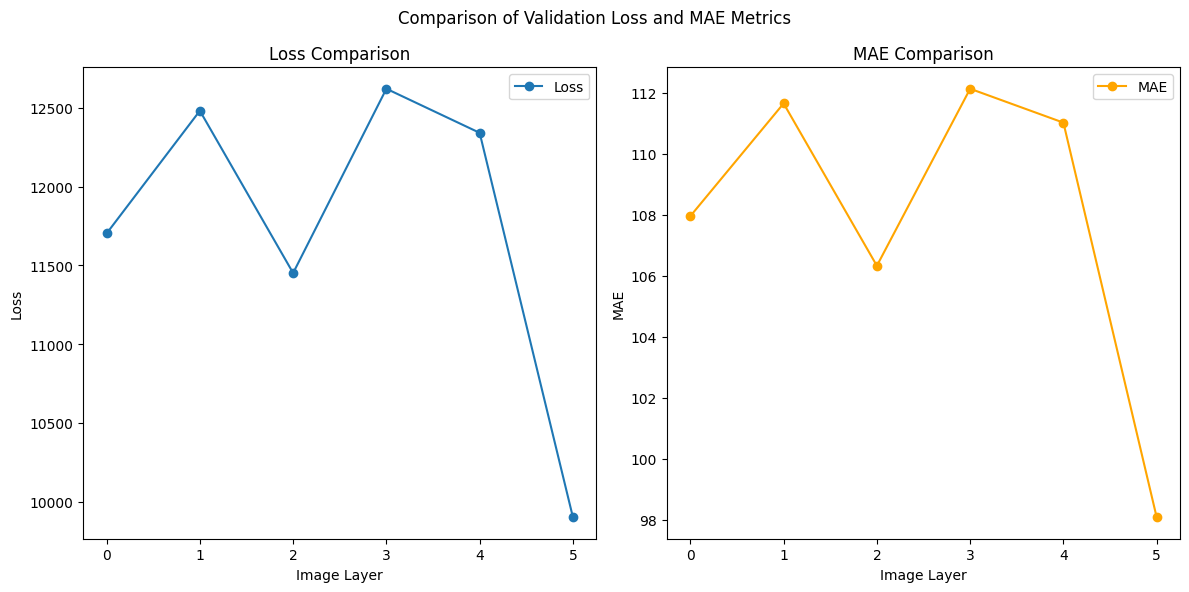

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have op_0 to op_5 arrays with loss and MAE values
# Replace these with your actual data

# Extract loss and MAE values
loss_values = [op[0] for op in [op_0, op_1, op_2, op_3, op_4, op_5]]
mae_values = [op[1] for op in [op_0, op_1, op_2, op_3, op_4, op_5]]

# Create subplots for loss and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss
ax1.plot(loss_values, marker='o', label='Loss')
ax1.set_title('Loss Comparison')
ax1.set_xlabel('Image Layer')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE
ax2.plot(mae_values, marker='o', color='orange', label='MAE')
ax2.set_title('MAE Comparison')
ax2.set_xlabel('Image Layer')
ax2.set_ylabel('MAE')
ax2.legend()
plt.suptitle('Comparison of Validation Loss and MAE Metrics')
plt.tight_layout()
plt.show()


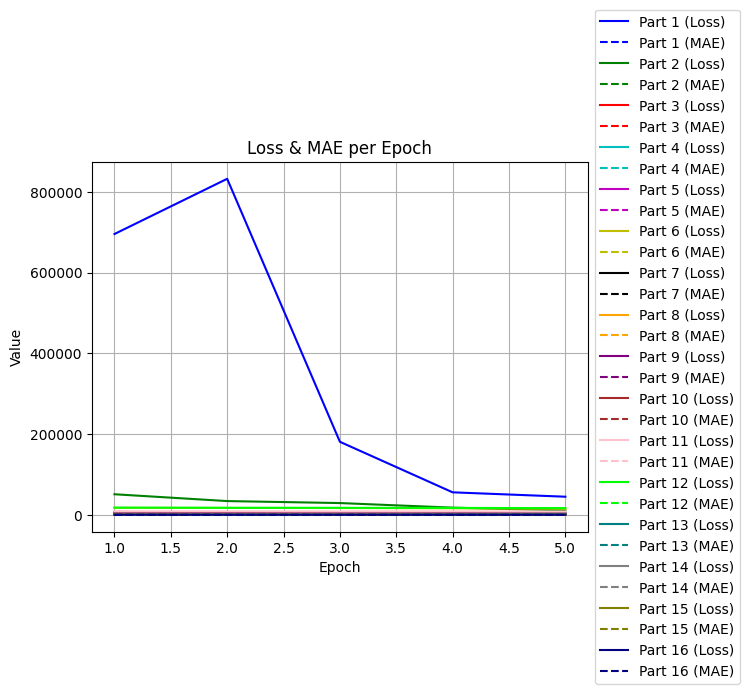

In [71]:
import matplotlib.pyplot as plt

colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

# Itera sobre cada full_history y grafica sus datos

for a in range(len(full_history_1)):
    # Extrae los valores de loss y mae de la full_history actual
    loss = full_history_1[a][0]
    mae = full_history_1[a][1]
    
    # Grafica los valores de loss
    plt.plot(range(1, len(loss) + 1), loss, label=str('Part ')+str(a+1) + ' (Loss)', color=colors[a])
    
    # Grafica los valores de mae
    plt.plot(range(1, len(mae) + 1), mae, label=str('Part ')+str(a+1) + ' (MAE)', linestyle='dashed', color=colors[a])

# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.title('Loss & MAE per Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Coloca la leyenda fuera del gráfico
plt.grid(True)

# Muestra el gráfico
plt.show()


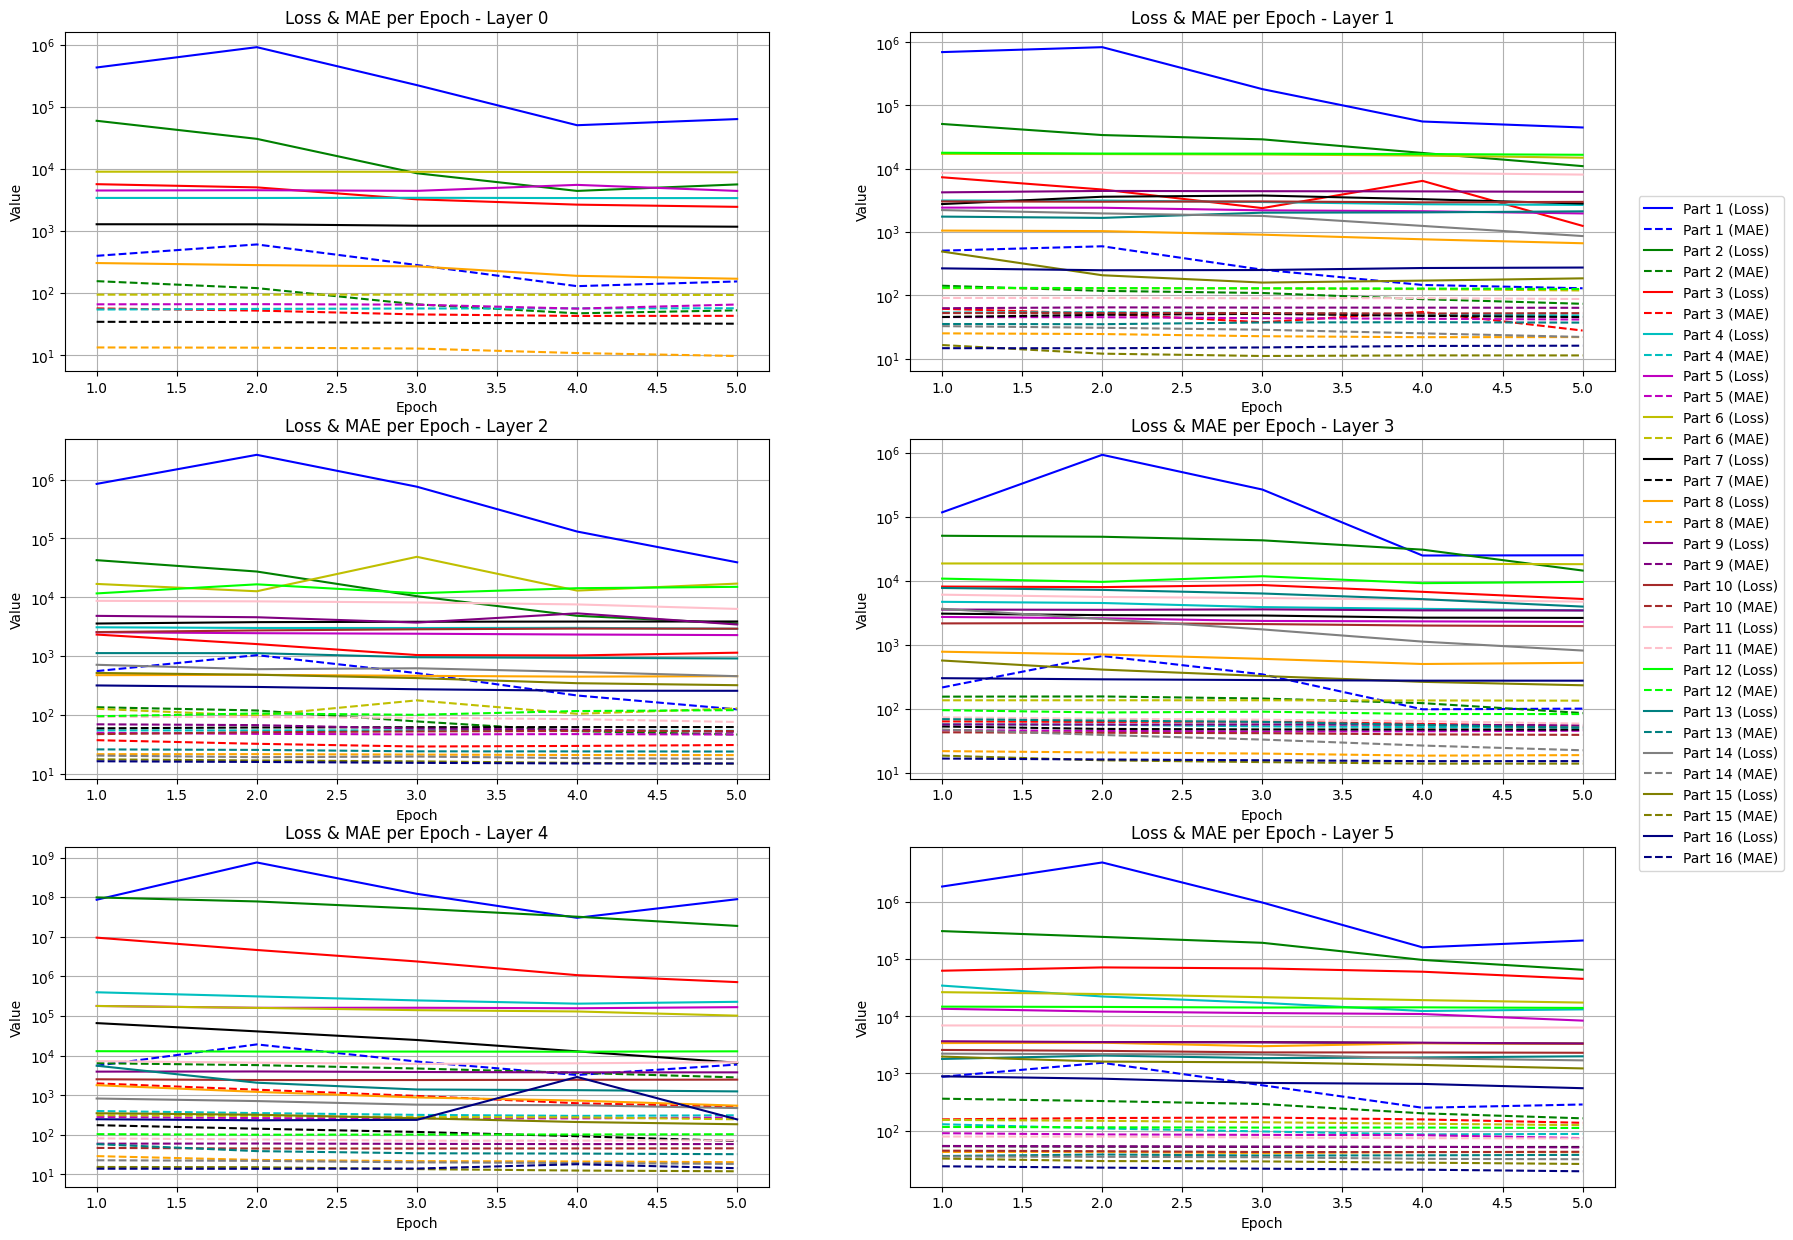

In [ ]:
num_filas = 3
num_columnas = 2
full_histories=[full_history_0,full_history_1,full_history_2,full_history_3,full_history_4,full_history_5]
# Crea la figura y los subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(20, 15))
for i in range(num_filas):
    for j in range(num_columnas):
        index = i * num_columnas + j
        if index < len(full_histories):
            for a in range(len(full_histories[i*2+j])):
                # Extrae los valores de loss y mae de la full_history actual
                loss = full_histories[i*2+j][a][0]
                mae = full_histories[i*2+j][a][1]
                
                # Grafica los valores de loss
                axs[i,j].plot(range(1, len(loss) + 1), loss, label=str('Part ')+str(a+1) + ' (Loss)', color=colors[a])
                
                # Grafica los valores de mae
                axs[i,j].plot(range(1, len(mae) + 1), mae, label=str('Part ')+str(a+1) + ' (MAE)', linestyle='dashed', color=colors[a])
                axs[i, j].set_xlabel('Epoch')
                axs[i, j].set_ylabel('Value')
                axs[i,j].set_yscale('symlog')
                axs[i, j].set_title('Loss & MAE per Epoch - Layer {}'.format(index))
                
                axs[i, j].grid(True)
plt.legend(loc='lower right',bbox_to_anchor=(1.25,0.91))
            


# Muestra la figura
plt.show()

In [ ]:
num_filas = 3
num_columnas = 2
full_histories=[full_history_0,full_history_1,full_history_2,full_history_3,full_history_4,full_history_5]
# Crea la figura y los subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(20, 15))
for i in range(num_filas):
    for j in range(num_columnas):
        index = i * num_columnas + j
        if index < len(full_histories):
            for a in range(len(full_histories[i*2+j])):
                # Extrae los valores de loss y mae de la full_history actual
                loss = full_histories[i*2+j][a][0]
                
                # Grafica los valores de loss
                axs[i,j].plot(range(1, len(loss) + 1), loss, label=str('Part ')+str(a+1) + ' (Loss)', color=colors[a])
                axs[i, j].set_xlabel('Epoch')
                axs[i, j].set_ylabel('Value')
                axs[i,j].set_yscale('symlog')
                axs[i, j].set_title('Loss per Epoch - Layer {}'.format(index))
                
                axs[i, j].grid(True)
plt.legend(loc='lower right',bbox_to_anchor=(1.25,0.91))
            


# Muestra la figura
plt.show()

In [ ]:
num_filas = 3
num_columnas = 2
full_histories=[full_history_0,full_history_1,full_history_2,full_history_3,full_history_4,full_history_5]
# Crea la figura y los subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(20, 15))
for i in range(num_filas):
    for j in range(num_columnas):
        index = i * num_columnas + j
        if index < len(full_histories):
            for a in range(len(full_histories[i*2+j])):
                # Extrae los valores de loss y mae de la full_history actual
                mae = full_histories[i*2+j][a][1]                
                # Grafica los valores de mae
                axs[i,j].plot(range(1, len(mae) + 1), mae, label=str('Part ')+str(a+1) + ' (MAE)', linestyle='dashed', color=colors[a])
                axs[i, j].set_xlabel('Epoch')
                axs[i, j].set_ylabel('Value')
                axs[i,j].set_yscale('symlog')
                axs[i, j].set_title('MAE per Epoch - Layer {}'.format(index))
                
                axs[i, j].grid(True)
plt.legend(loc='lower right',bbox_to_anchor=(1.25,0.91))
            


# Muestra la figura
plt.show()